In [316]:
import numpy as np
from scipy import stats
import pandas as pd
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import f
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.utils import resample
import statsmodels.stats.multitest as smt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as Naive_Bayes
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
#from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier

In [115]:
data = pd.read_excel('PD_data.xlsx')

In [116]:
data.shape

(195, 24)

In [117]:
data.isna().sum().sort_values(ascending=False)

name                0
MDVP:Fo(Hz)         0
PPE                 0
D2                  0
spread2             0
spread1             0
DFA                 0
RPDE                0
HNR                 0
NHR                 0
Shimmer:DDA         0
MDVP:APQ            0
Shimmer:APQ5        0
Shimmer:APQ3        0
MDVP:Shimmer(dB)    0
MDVP:Shimmer        0
Jitter:DDP          0
MDVP:PPQ            0
MDVP:RAP            0
MDVP:Jitter(Abs)    0
MDVP:Jitter(%)      0
MDVP:Flo(Hz)        0
MDVP:Fhi(Hz)        0
status              0
dtype: int64

In [118]:
data.dtypes

name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
status                int64
dtype: object

In [119]:
data.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE', 'status'],
      dtype='object')

In [132]:
num_cols = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)','MDVP:Jitter(%)', 
            'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 
            'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 
            'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE', 'status']

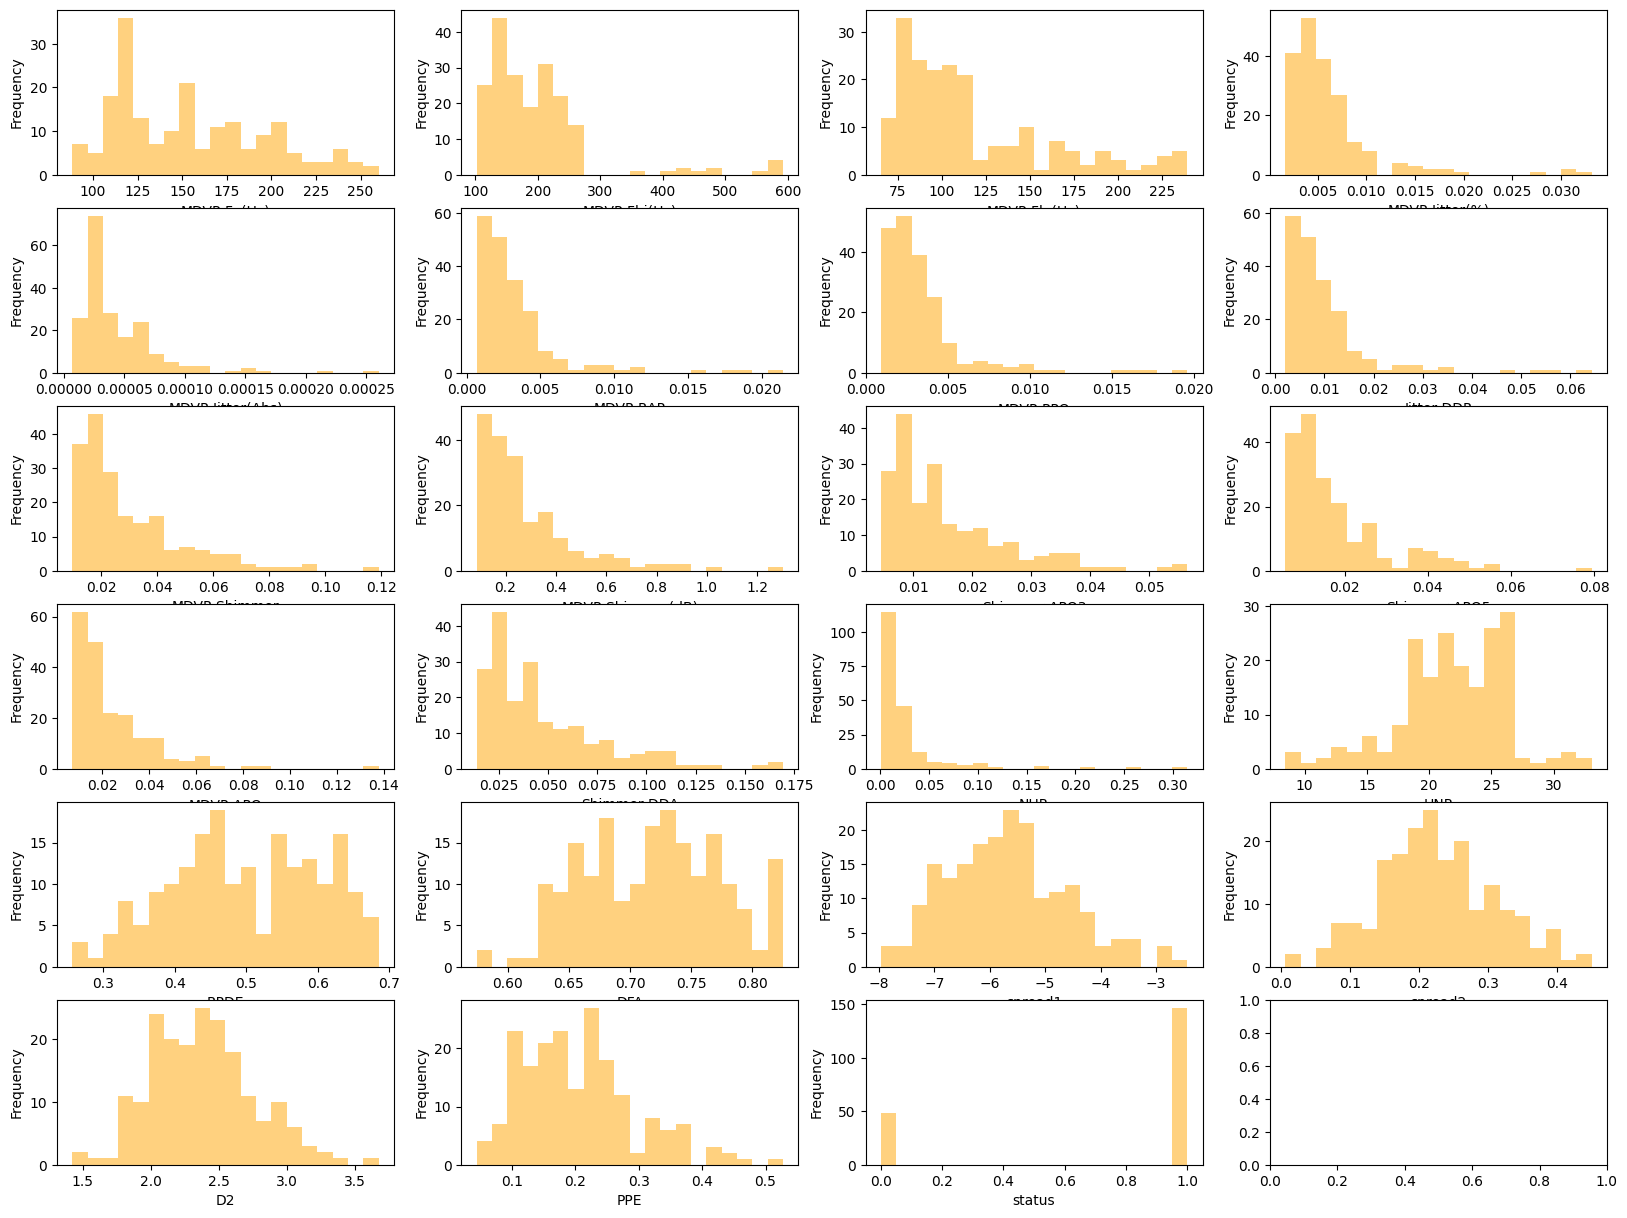

In [133]:
num_plots = len(num_cols)
num_rows = 6
no_cols = int(num_plots / num_rows) + (num_plots % num_rows > 0)
fig, axs = plt.subplots(nrows=num_rows, ncols=no_cols, figsize=(20, 15))

# iterate over the columns and plot a histogram for each numeric column
row = 0
col = 0
for column in num_cols:
    axs[row, col].hist(data[column], alpha=0.5, bins=20, color='orange')
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Frequency')
    if col == (no_cols - 1):
        row += 1
        col = 0
    else:
        col += 1

# show the plot
plt.show()

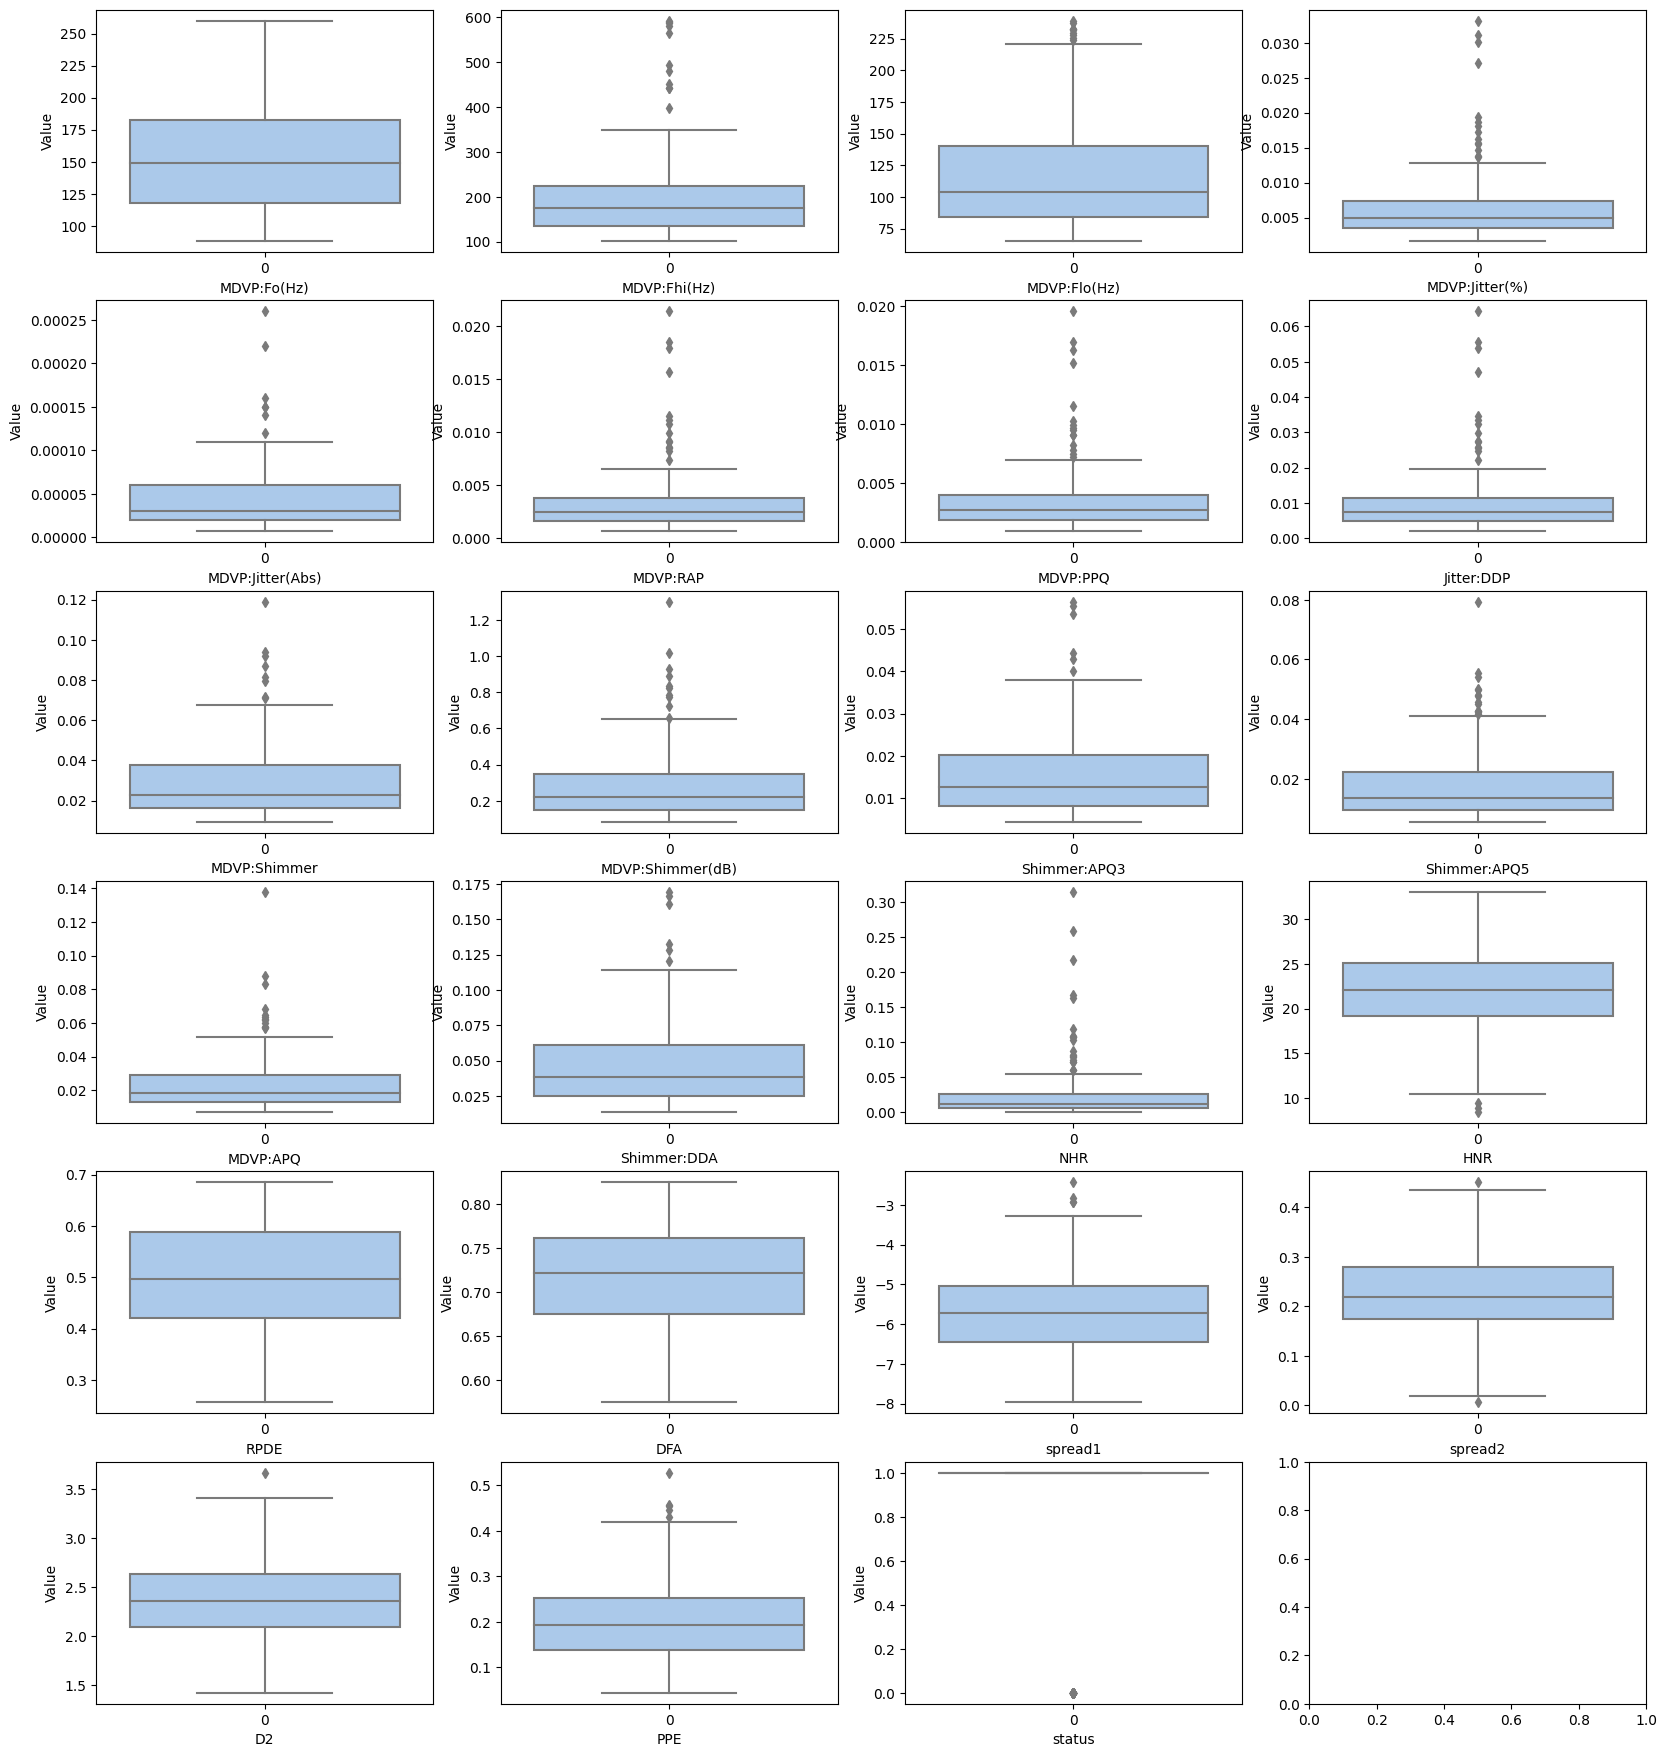

In [134]:
num_plots = len(num_cols)
num_rows = 6
n_cols = 4
fig, axs = plt.subplots(nrows=num_rows, ncols=n_cols, figsize=(20, 22))
# iterate over the columns and plot a box plot for each numeric column
row = 0
col = 0
for column in num_cols:
    sns.boxplot(data=data[column], ax=axs[row, col], palette="pastel")
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Value')
    if col == (n_cols - 1):
        row += 1
        col = 0
    else:
        col += 1

# show the plot
plt.show()

In [135]:
def f_test(df, independent_var, target_var):
    """
    Perform an F-test for equality of variances between two groups based on a binary target variable.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        independent_var (str): The name of the column containing the independent variable.
        target_var (str): The name of the column containing the binary target variable.

    Returns:
        A tuple containing the F-statistic and the p-value for the F-test.
    """
    # Split the data into two groups based on the binary target variable
    group1 = df.loc[df[target_var] == 0, independent_var]
    group2 = df.loc[df[target_var] == 1, independent_var]

    # Calculate the variances of the independent variable for each group
    var1 = group1.var(ddof=1)
    var2 = group2.var(ddof=1)

    # Calculate the F-statistic
    f_stat = var1 / var2

    # Calculate the degrees of freedom for the F-distribution
    df1 = len(group1) - 1
    df2 = len(group2) - 1

    # Calculate the p-value for the F-test
    p_value = f.sf(f_stat, df1, df2)

    # Return the F-statistic and the p-value
    return f_stat, p_value


ftest_results = pd.DataFrame(columns=['Independent Variable', 'F-Statistic', 'p-value'])

# Iterate over the columns in the DataFrame and apply the f_test function to each one
for col in num_cols:
    f_stat, p_value = f_test(data, col, 'status')
    ftest_results = ftest_results.append({'Independent Variable': col, 'F-Statistic': f_stat, 'p-value': p_value}, ignore_index=True)

# Print the results table
print(ftest_results)


   Independent Variable  F-Statistic       p-value
0           MDVP:Fo(Hz)     2.657278  4.433757e-06
1          MDVP:Fhi(Hz)     1.198918  2.075789e-01
2          MDVP:Flo(Hz)     3.314401  1.932652e-08
3        MDVP:Jitter(%)     0.153758  1.000000e+00
4      MDVP:Jitter(Abs)     0.165384  1.000000e+00
5              MDVP:RAP     0.108208  1.000000e+00
6              MDVP:PPQ     0.099025  1.000000e+00
7            Jitter:DDP     0.108263  1.000000e+00
8          MDVP:Shimmer     0.077082  1.000000e+00
9      MDVP:Shimmer(dB)     0.077429  1.000000e+00
10         Shimmer:APQ3     0.102454  1.000000e+00
11         Shimmer:APQ5     0.063252  1.000000e+00
12             MDVP:APQ     0.044848  1.000000e+00
13          Shimmer:DDA     0.102463  1.000000e+00
14                  NHR     0.184438  1.000000e+00
15                  HNR     0.626512  9.674013e-01
16                 RPDE     0.829134  7.685942e-01
17                  DFA     0.878352  6.909394e-01
18              spread1     0.4

/var/folders/wy/y81s23xx1qdf2640d4mj4g500000gn/T/ipykernel_55147/1483611799.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ftest_results = ftest_results.append({'Independent Variable': col, 'F-Statistic': f_stat, 'p-value': p_value}, ignore_index=True)
/var/folders/wy/y81s23xx1qdf2640d4mj4g500000gn/T/ipykernel_55147/1483611799.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ftest_results = ftest_results.append({'Independent Variable': col, 'F-Statistic': f_stat, 'p-value': p_value}, ignore_index=True)
/var/folders/wy/y81s23xx1qdf2640d4mj4g500000gn/T/ipykernel_55147/1483611799.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ftest_results = ftest_results.append({'Independent Variable': col, 'F-Statistic': f_st

In [136]:
corr_matrix = data[num_cols].corr()

# compute the p-values for the correlation coefficients
p_values = data[num_cols].corr(method=lambda x, y: stats.pearsonr(x, y)[1].round(3)) - np.eye(len(num_cols))

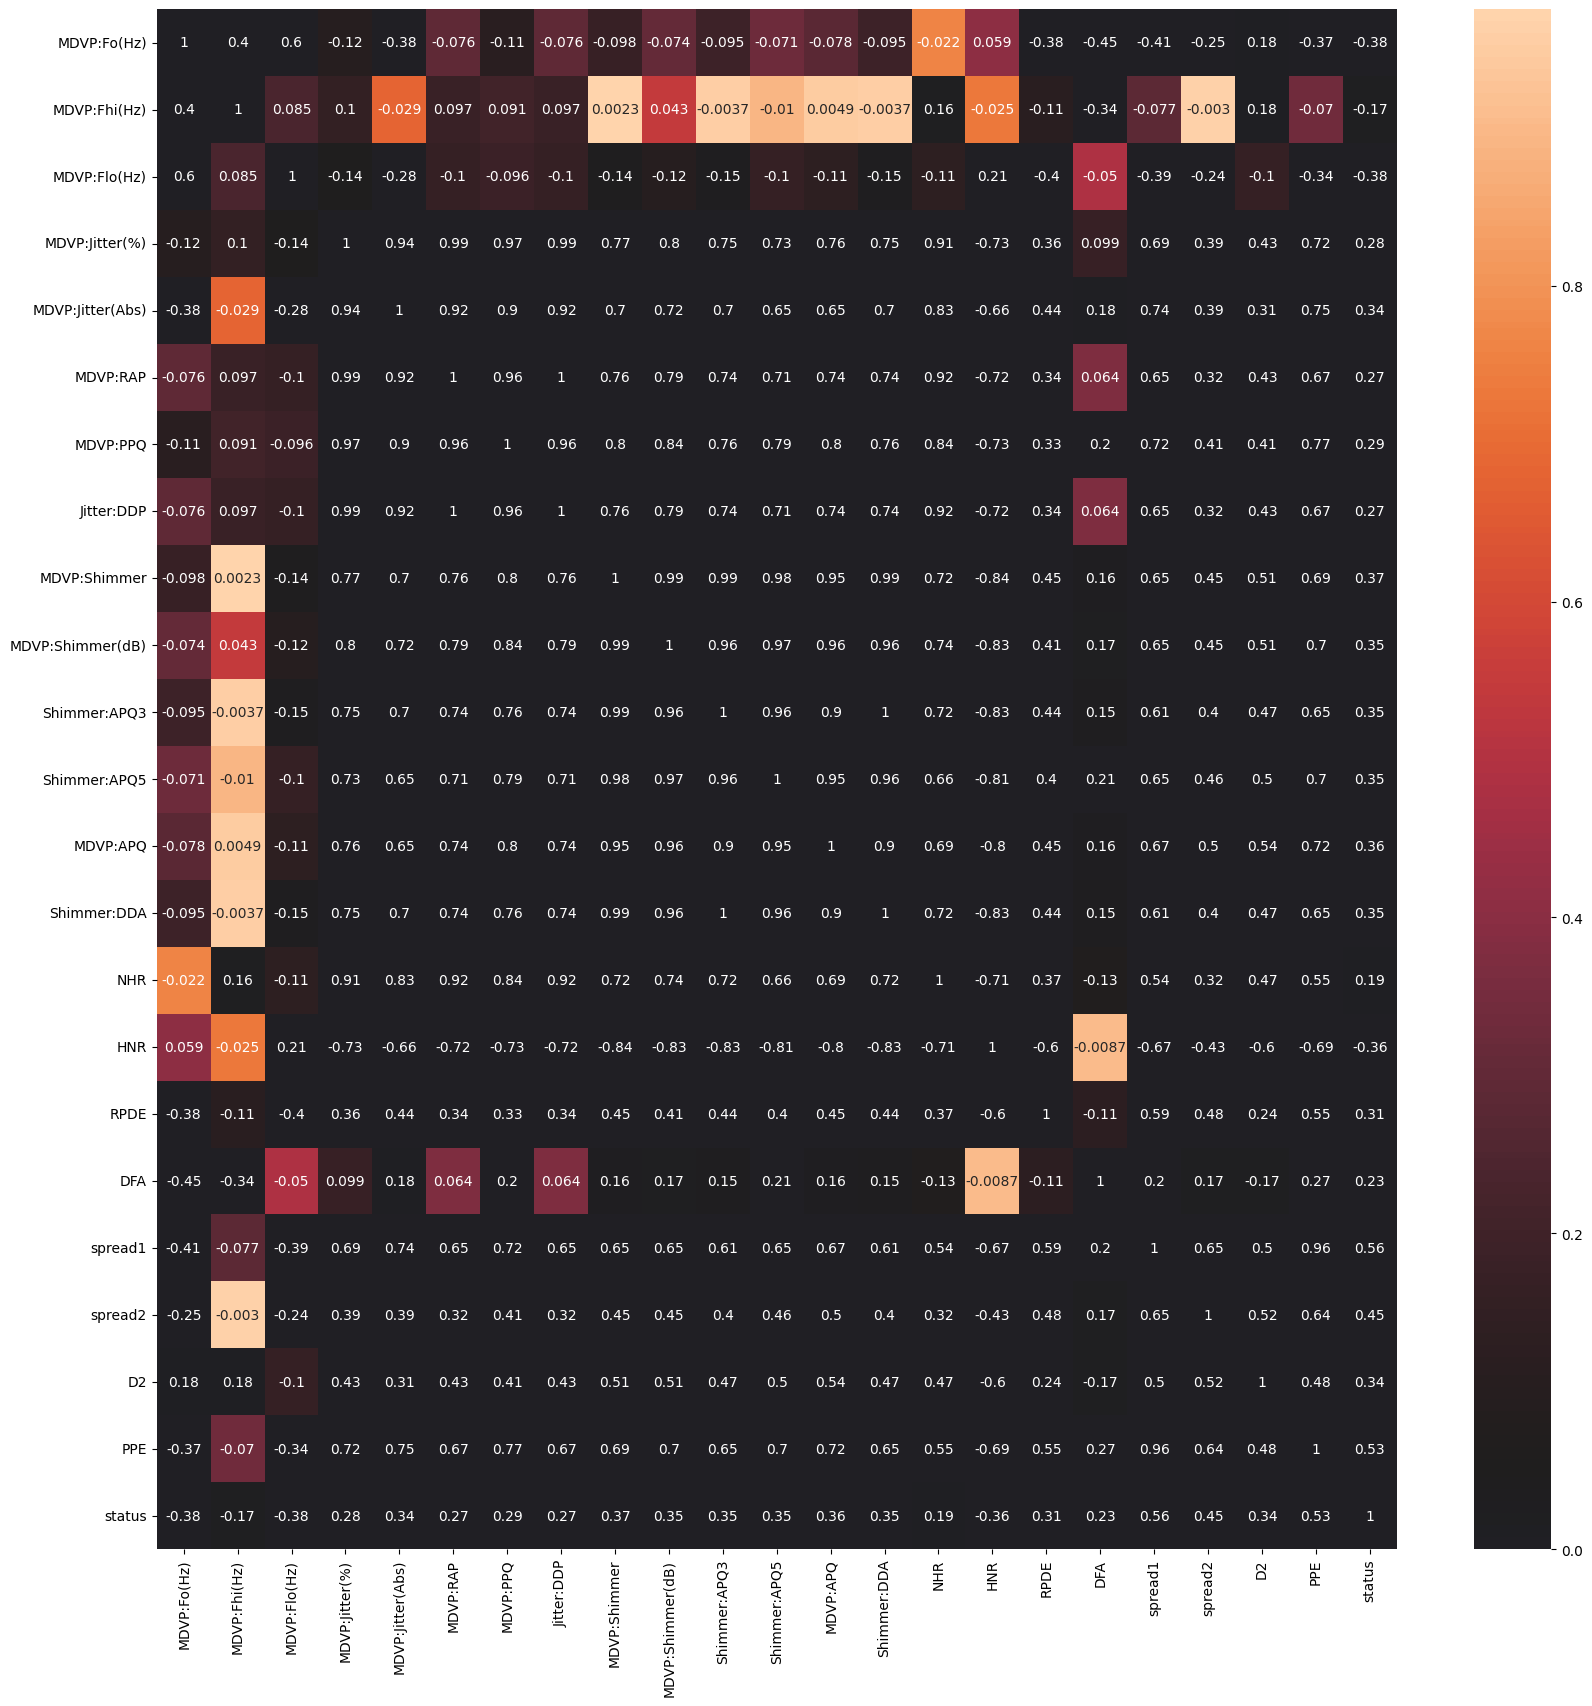

In [137]:
plt.figure(figsize=(20,20))
plot = sns.heatmap(p_values, annot = corr_matrix, center = 0.05)

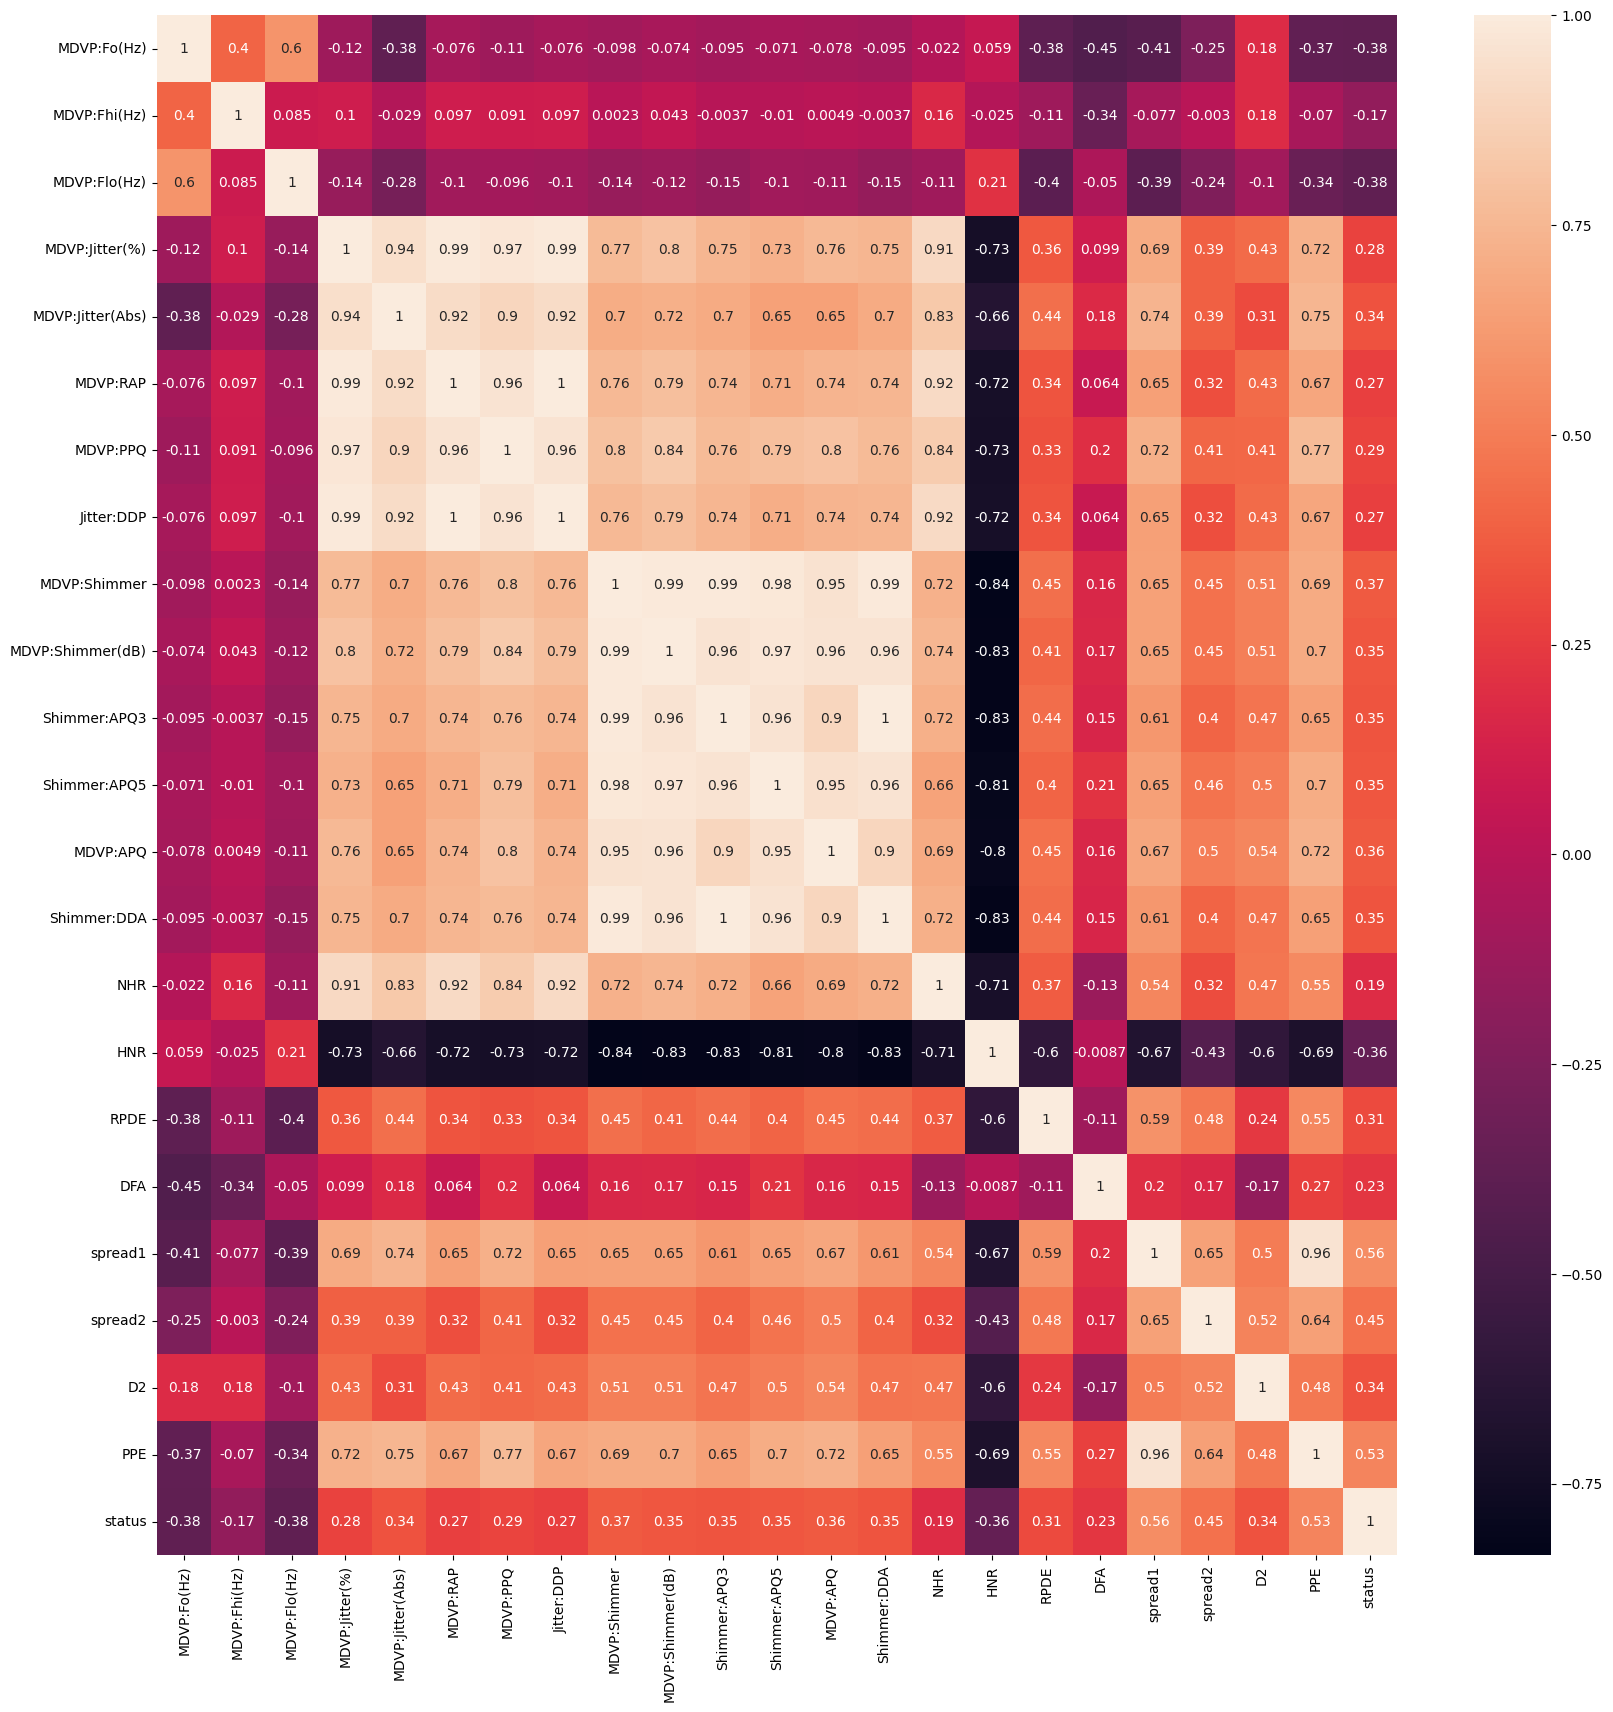

In [139]:
plt.figure(figsize=(20,20))
plot = sns.heatmap(corr_matrix, annot = corr_matrix)

In [280]:
variation_freq = ['MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP']
variation_amp = ['MDVP:Shimmer', 'MDVP:Shimmer(dB)','Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA']
fund_freq_vars = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'status']

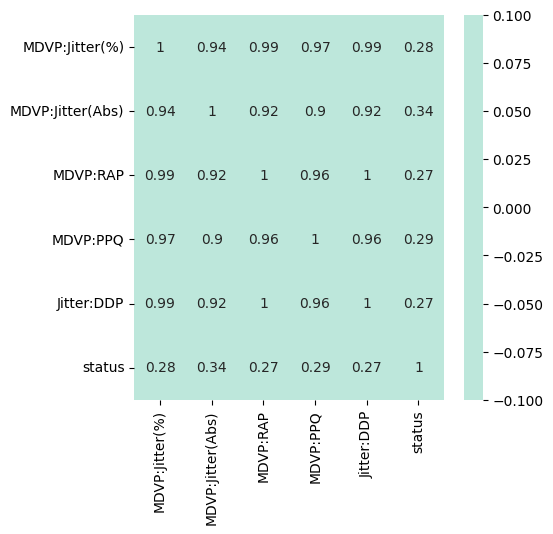

In [143]:
frequency_corr_matrix = data[variation_freq].corr()

# compute the p-values for the correlation coefficients
frequency_p_values = data[variation_freq].corr(method=lambda x, y: stats.pearsonr(x, y)[1].round(3)) - np.eye(len(variation_freq))

plt.figure(figsize=(5,5))
plot = sns.heatmap(frequency_p_values, annot = frequency_corr_matrix, center = 0.05)

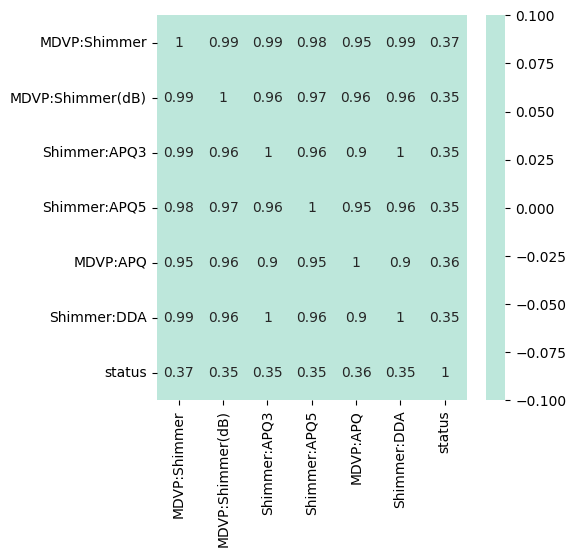

In [144]:
amplitude_corr_matrix = data[variation_amp].corr()

# compute the p-values for the correlation coefficients
amplitude_p_values = data[variation_amp].corr(method=lambda x, y: stats.pearsonr(x, y)[1].round(3)) - np.eye(len(variation_amp))

plt.figure(figsize=(5,5))
plot = sns.heatmap(amplitude_p_values, annot = amplitude_corr_matrix, center = 0.05)

In [145]:
print(amplitude_p_values)
print(frequency_p_values)

                  MDVP:Shimmer  MDVP:Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  \
MDVP:Shimmer               0.0               0.0           0.0           0.0   
MDVP:Shimmer(dB)           0.0               0.0           0.0           0.0   
Shimmer:APQ3               0.0               0.0           0.0           0.0   
Shimmer:APQ5               0.0               0.0           0.0           0.0   
MDVP:APQ                   0.0               0.0           0.0           0.0   
Shimmer:DDA                0.0               0.0           0.0           0.0   
status                     0.0               0.0           0.0           0.0   

                  MDVP:APQ  Shimmer:DDA  status  
MDVP:Shimmer           0.0          0.0     0.0  
MDVP:Shimmer(dB)       0.0          0.0     0.0  
Shimmer:APQ3           0.0          0.0     0.0  
Shimmer:APQ5           0.0          0.0     0.0  
MDVP:APQ               0.0          0.0     0.0  
Shimmer:DDA            0.0          0.0     0.0  
status   

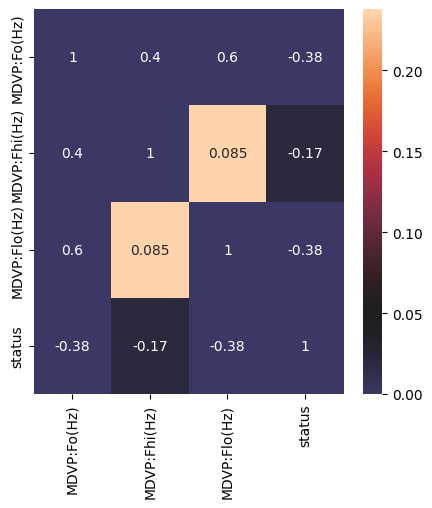

In [146]:
fundfreq_corr_matrix = data[fund_freq_vars].corr()

# compute the p-values for the correlation coefficients
fundfreq_p_values = data[fund_freq_vars].corr(method=lambda x, y: stats.pearsonr(x, y)[1].round(3)) - np.eye(len(fund_freq_vars))

plt.figure(figsize=(5,5))
plot = sns.heatmap(fundfreq_p_values, annot = fundfreq_corr_matrix, center = 0.05)

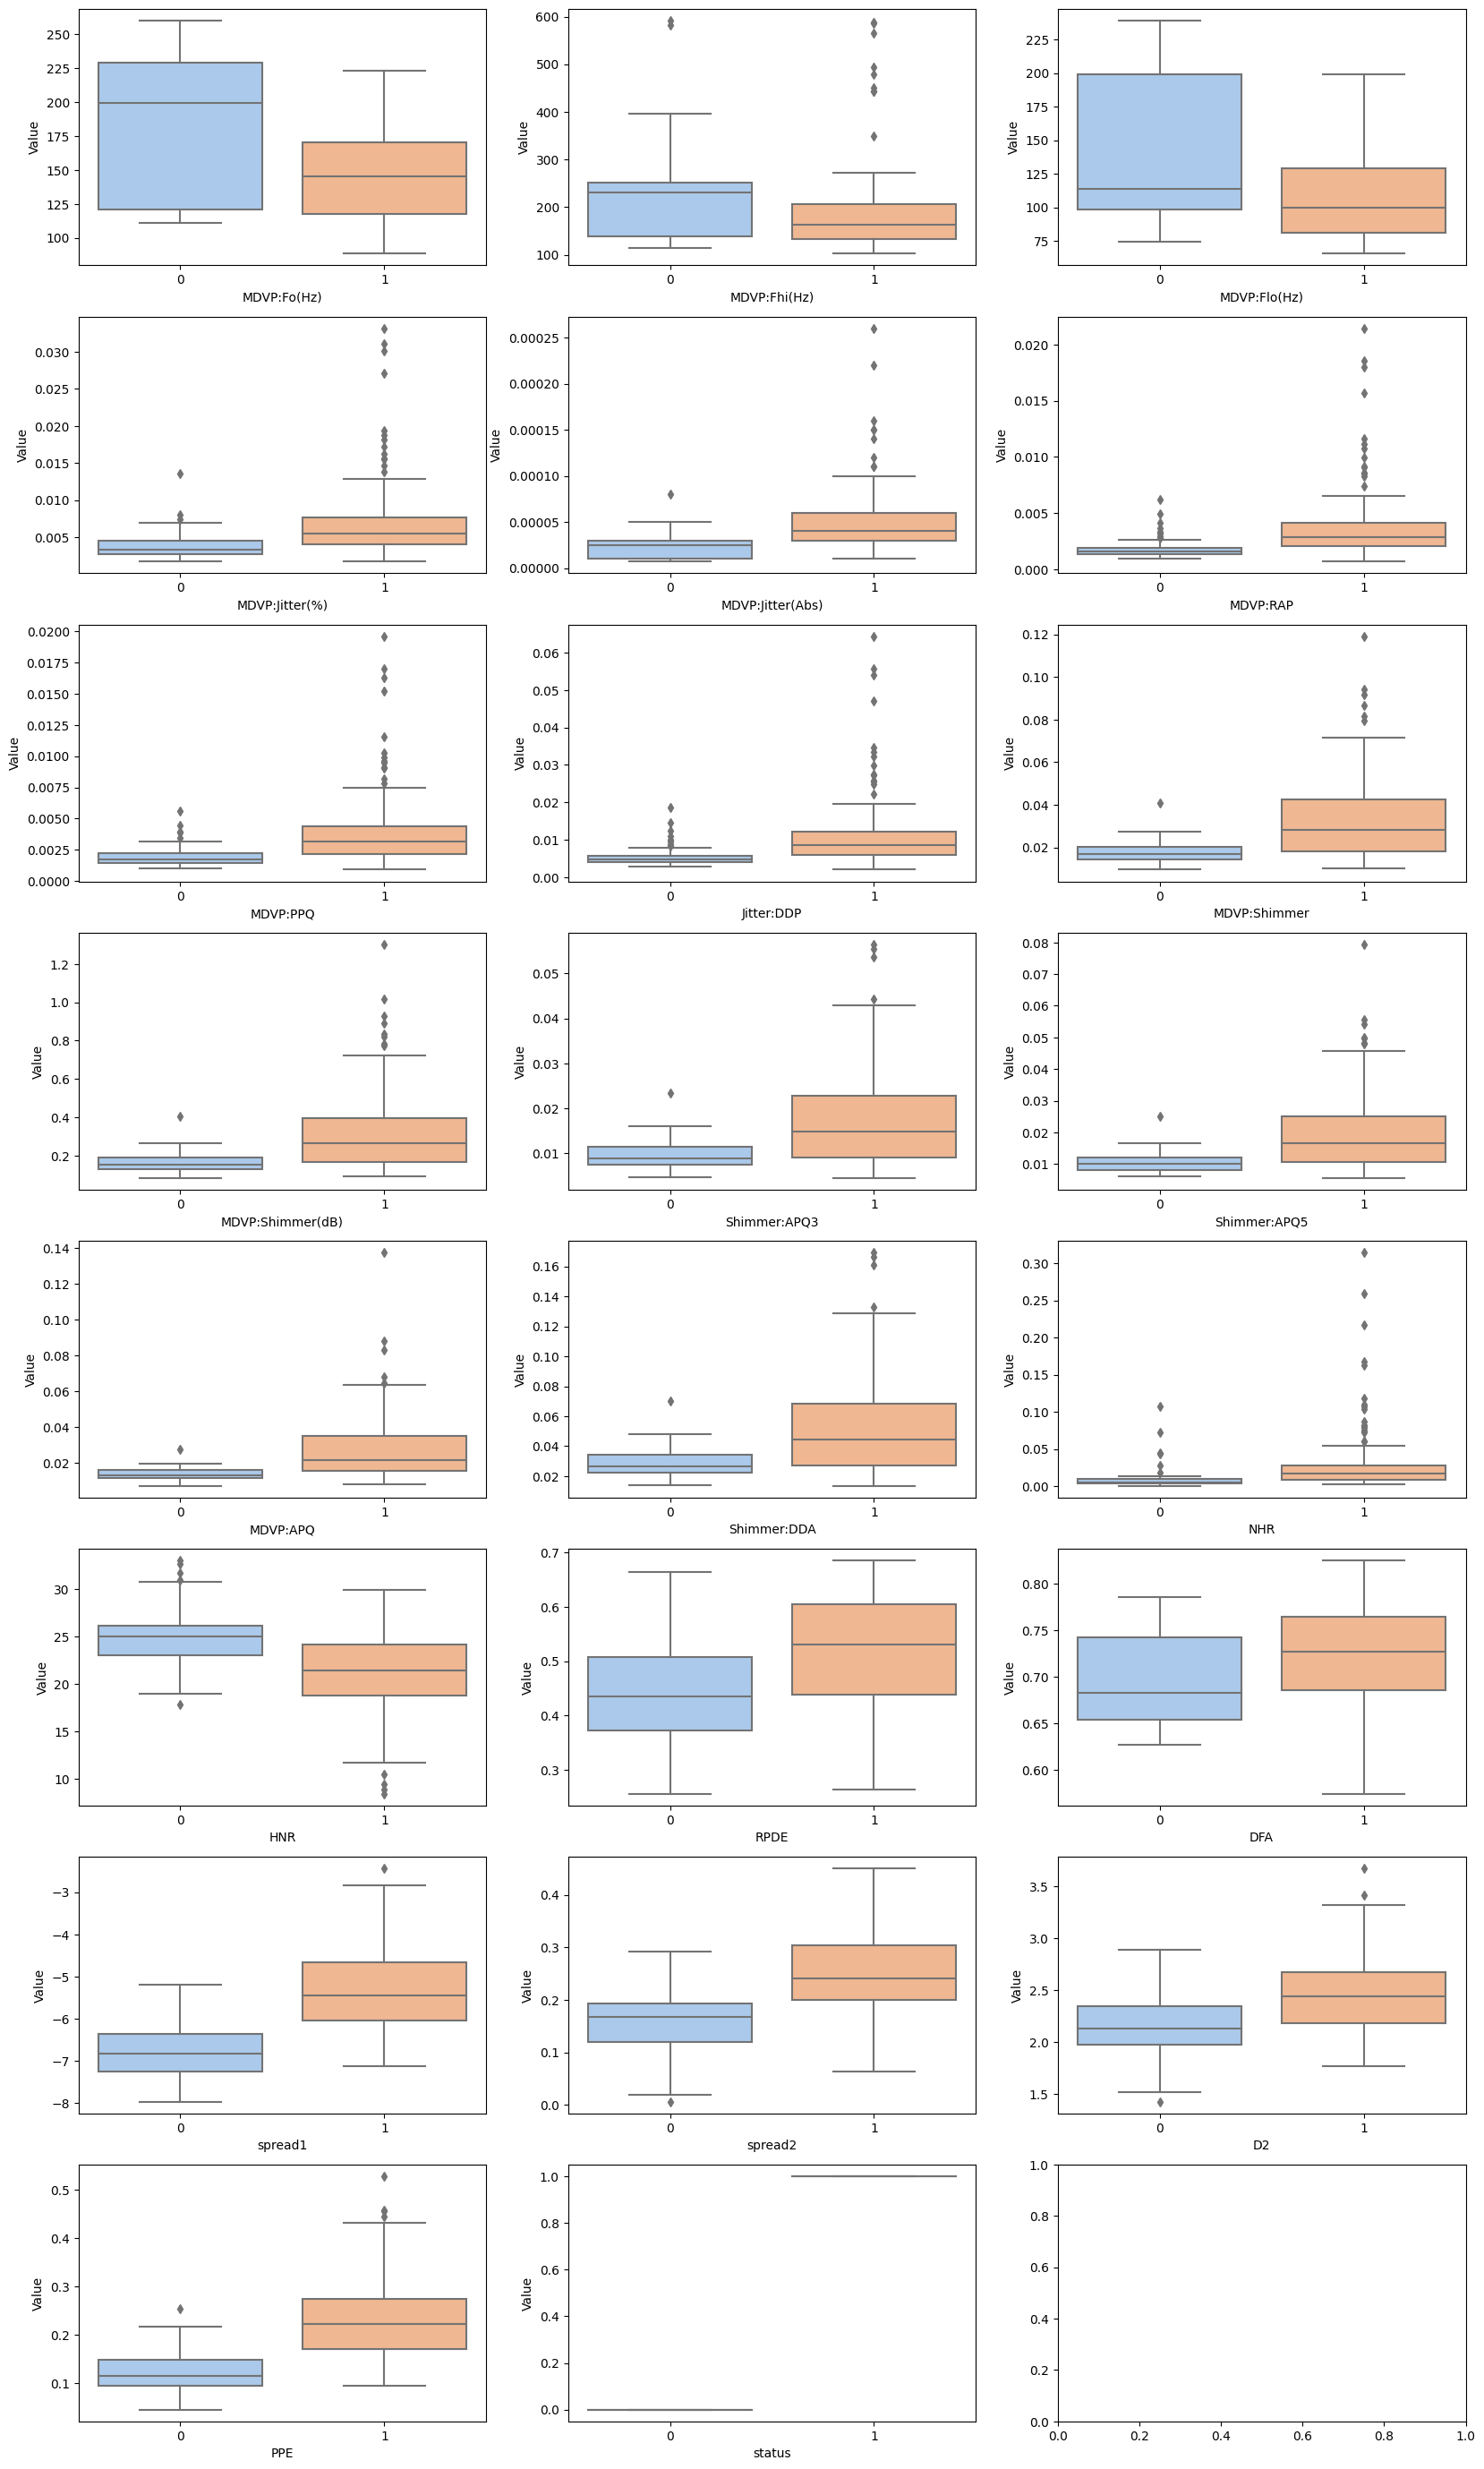

In [147]:
num_plots = len(num_cols)
num_rows = 8
n_cols = 3
fig, axs = plt.subplots(nrows=num_rows, ncols=n_cols, figsize=(20, 35))
# iterate over the columns and plot a box plot for each numeric column
row = 0
col = 0
for column in num_cols:
    sns.boxplot(x='status',y=column, data=data, ax=axs[row, col], palette="pastel")
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Value')
    if col == (n_cols - 1):
        row += 1
        col = 0
    else:
        col += 1

# show the plot
plt.show()

In [148]:
def count_outliers_iqr(column):
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    upper_threshold = q3 + 1.5 * iqr
    lower_threshold = q1 - 1.5 * iqr
    num_outliers = sum((column > upper_threshold) | (column < lower_threshold))
    return num_outliers

for col in num_cols:
    num_outliers = count_outliers_iqr(data[col])
    print(f"Number of outliers in {col}: {num_outliers}")

Number of outliers in MDVP:Fo(Hz): 0
Number of outliers in MDVP:Fhi(Hz): 11
Number of outliers in MDVP:Flo(Hz): 9
Number of outliers in MDVP:Jitter(%): 14
Number of outliers in MDVP:Jitter(Abs): 7
Number of outliers in MDVP:RAP: 14
Number of outliers in MDVP:PPQ: 15
Number of outliers in Jitter:DDP: 14
Number of outliers in MDVP:Shimmer: 8
Number of outliers in MDVP:Shimmer(dB): 10
Number of outliers in Shimmer:APQ3: 6
Number of outliers in Shimmer:APQ5: 13
Number of outliers in MDVP:APQ: 12
Number of outliers in Shimmer:DDA: 6
Number of outliers in NHR: 19
Number of outliers in HNR: 3
Number of outliers in RPDE: 0
Number of outliers in DFA: 0
Number of outliers in spread1: 4
Number of outliers in spread2: 2
Number of outliers in D2: 1
Number of outliers in PPE: 5
Number of outliers in status: 48


In [222]:
data['MDVP:F_Spd'] = data['MDVP:Fhi(Hz)'] - data['MDVP:Flo(Hz)']

In [223]:
df = data
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE', 'status', 'MDVP:F_Spd'],
      dtype='object')

In [224]:
df = df.drop(['name','status'], axis = 1)

In [225]:
df.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE', 'MDVP:F_Spd'],
      dtype='object')

In [226]:
# Standardize the data in the new dataframe
scaler = StandardScaler()
df_scale = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scale, columns=['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 
                                            'MDVP:Jitter(%)','MDVP:Jitter(Abs)', 'MDVP:RAP', 
                                            'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 
                                            'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
                                            'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 
                                            'spread1', 'spread2', 'D2', 'PPE', 'MDVP:F_Spd'])

In [176]:
df_scaled = df_scaled.drop(['MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 
                          'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 
                          'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)'], axis = 1)

In [214]:
df_scaled.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE', 'MDVP:F_Spd', 'status'],
      dtype='object')

In [213]:
df_scaled['status'] = data['status'].copy()

In [180]:
corr_matrix = df_scaled.corr()

# compute the p-values for the correlation coefficients
p_values = df_scaled.corr(method=lambda x, y: stats.pearsonr(x, y)[1].round(3)) - np.eye(len(df_scaled.columns))

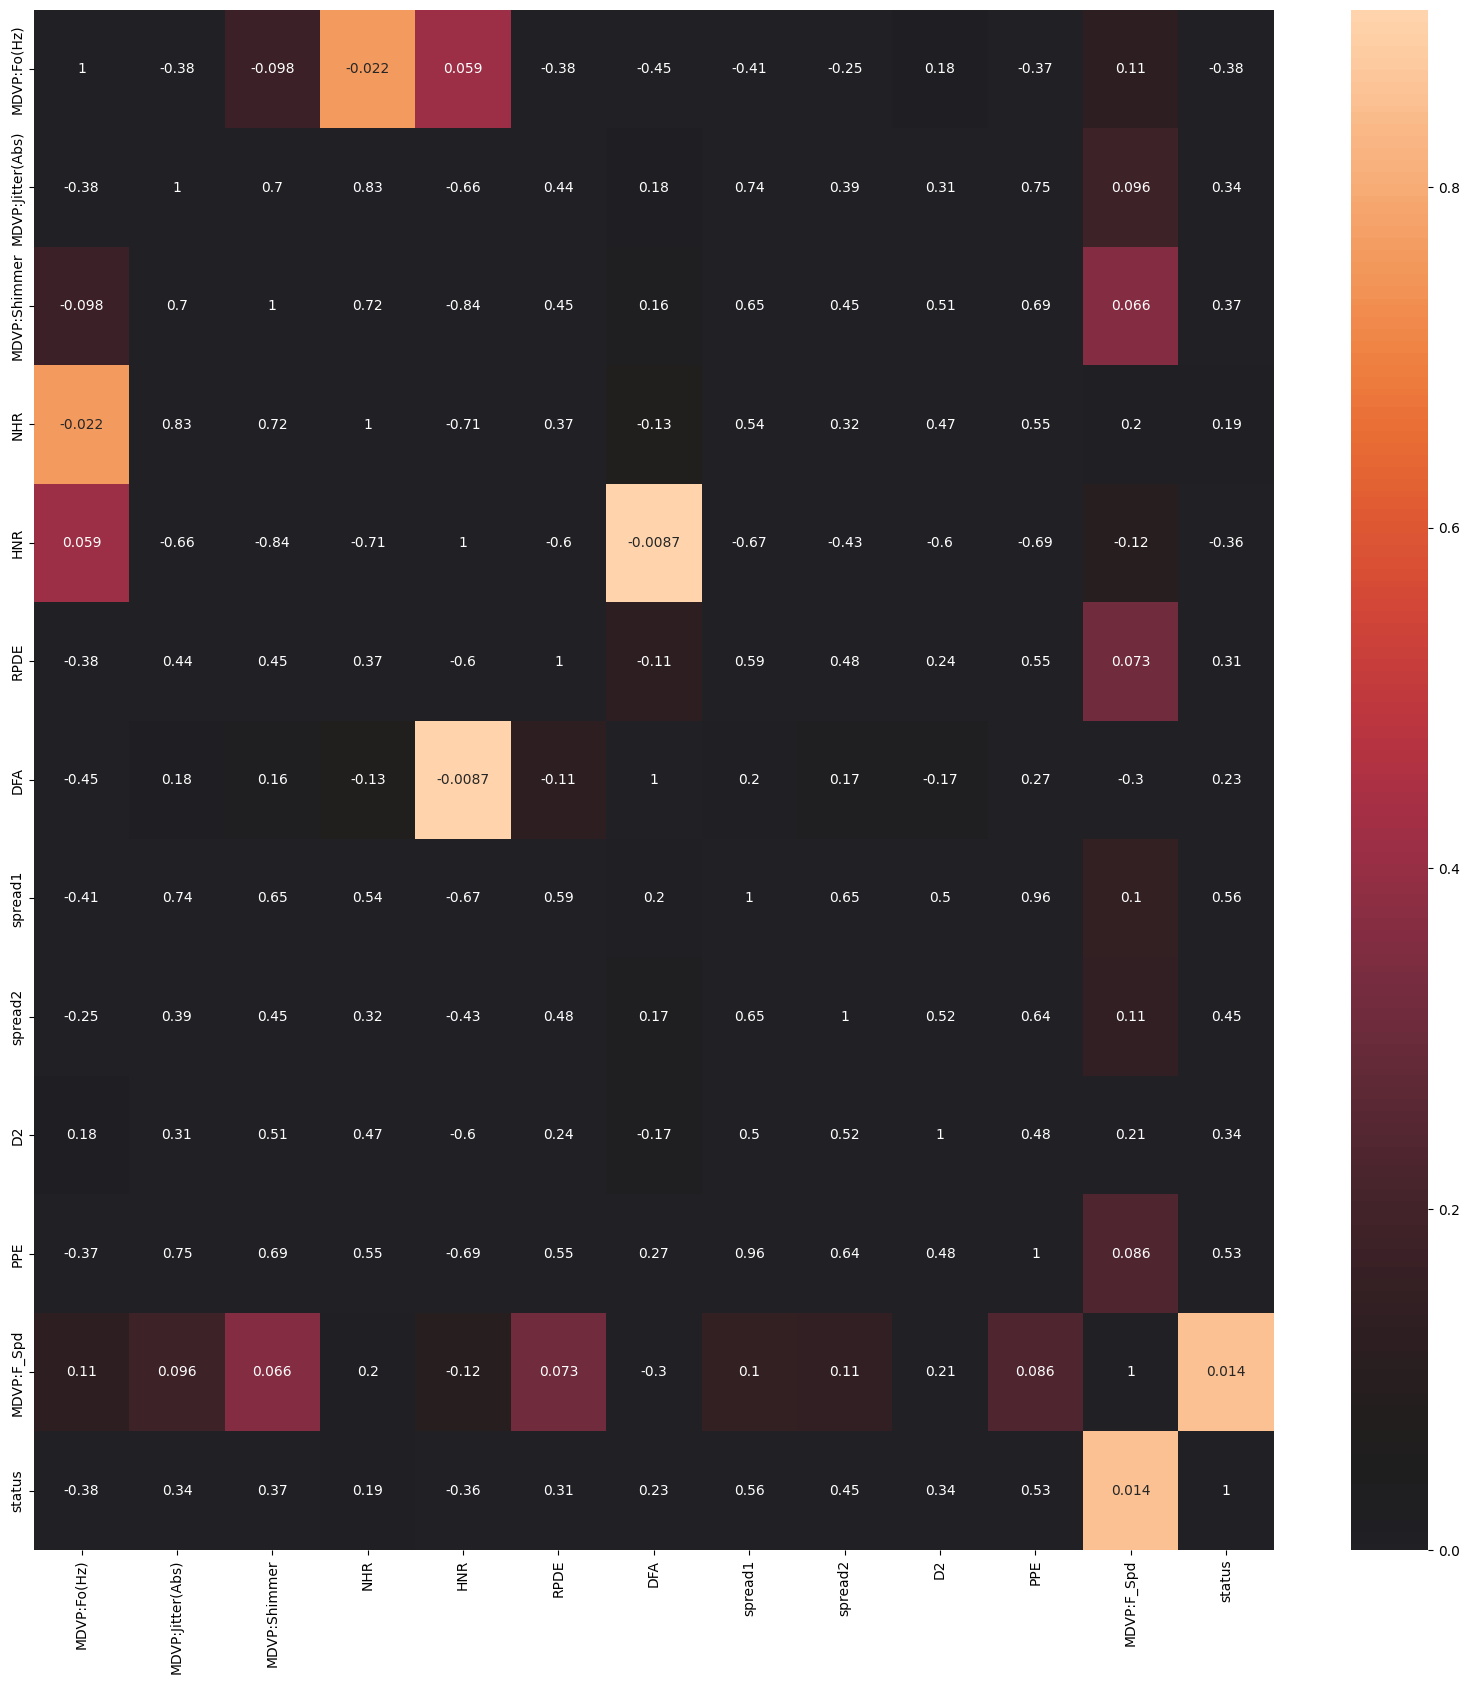

In [181]:
plt.figure(figsize=(20,20))
plot = sns.heatmap(p_values, annot = corr_matrix, center = 0.05)

In [182]:
ftest_scaled_results = pd.DataFrame(columns=['Independent Variable', 'F-Statistic', 'p-value'])
scale_cols = ['MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer', 'NHR', 'HNR', 'RPDE','DFA', 
              'spread1', 'spread2', 'D2', 'PPE', 'MDVP:F_Spd']

# Iterate over the columns in the DataFrame and apply the f_test function to each one
for col in scale_cols:
    f_stat, p_value = f_test(df_scaled, col, 'status')
    ftest_scaled_results = ftest_scaled_results.append({'Independent Variable': col, 'F-Statistic': f_stat, 'p-value': p_value}, ignore_index=True)

# Print the results table
print(ftest_scaled_results)


   Independent Variable  F-Statistic   p-value
0           MDVP:Fo(Hz)     2.657278  0.000004
1      MDVP:Jitter(Abs)     0.165384  1.000000
2          MDVP:Shimmer     0.077082  1.000000
3                   NHR     0.184438  1.000000
4                   HNR     0.626512  0.967401
5                  RPDE     0.829134  0.768594
6                   DFA     0.878352  0.690939
7               spread1     0.438404  0.999240
8               spread2     0.655199  0.952602
9                    D2     0.681864  0.935105
10                  PPE     0.282867  0.999998
11           MDVP:F_Spd     1.382442  0.075175


/var/folders/wy/y81s23xx1qdf2640d4mj4g500000gn/T/ipykernel_55147/550281234.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ftest_scaled_results = ftest_scaled_results.append({'Independent Variable': col, 'F-Statistic': f_stat, 'p-value': p_value}, ignore_index=True)
/var/folders/wy/y81s23xx1qdf2640d4mj4g500000gn/T/ipykernel_55147/550281234.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ftest_scaled_results = ftest_scaled_results.append({'Independent Variable': col, 'F-Statistic': f_stat, 'p-value': p_value}, ignore_index=True)
/var/folders/wy/y81s23xx1qdf2640d4mj4g500000gn/T/ipykernel_55147/550281234.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ftest_scaled_results = ftest_scaled_results.append({'Independent

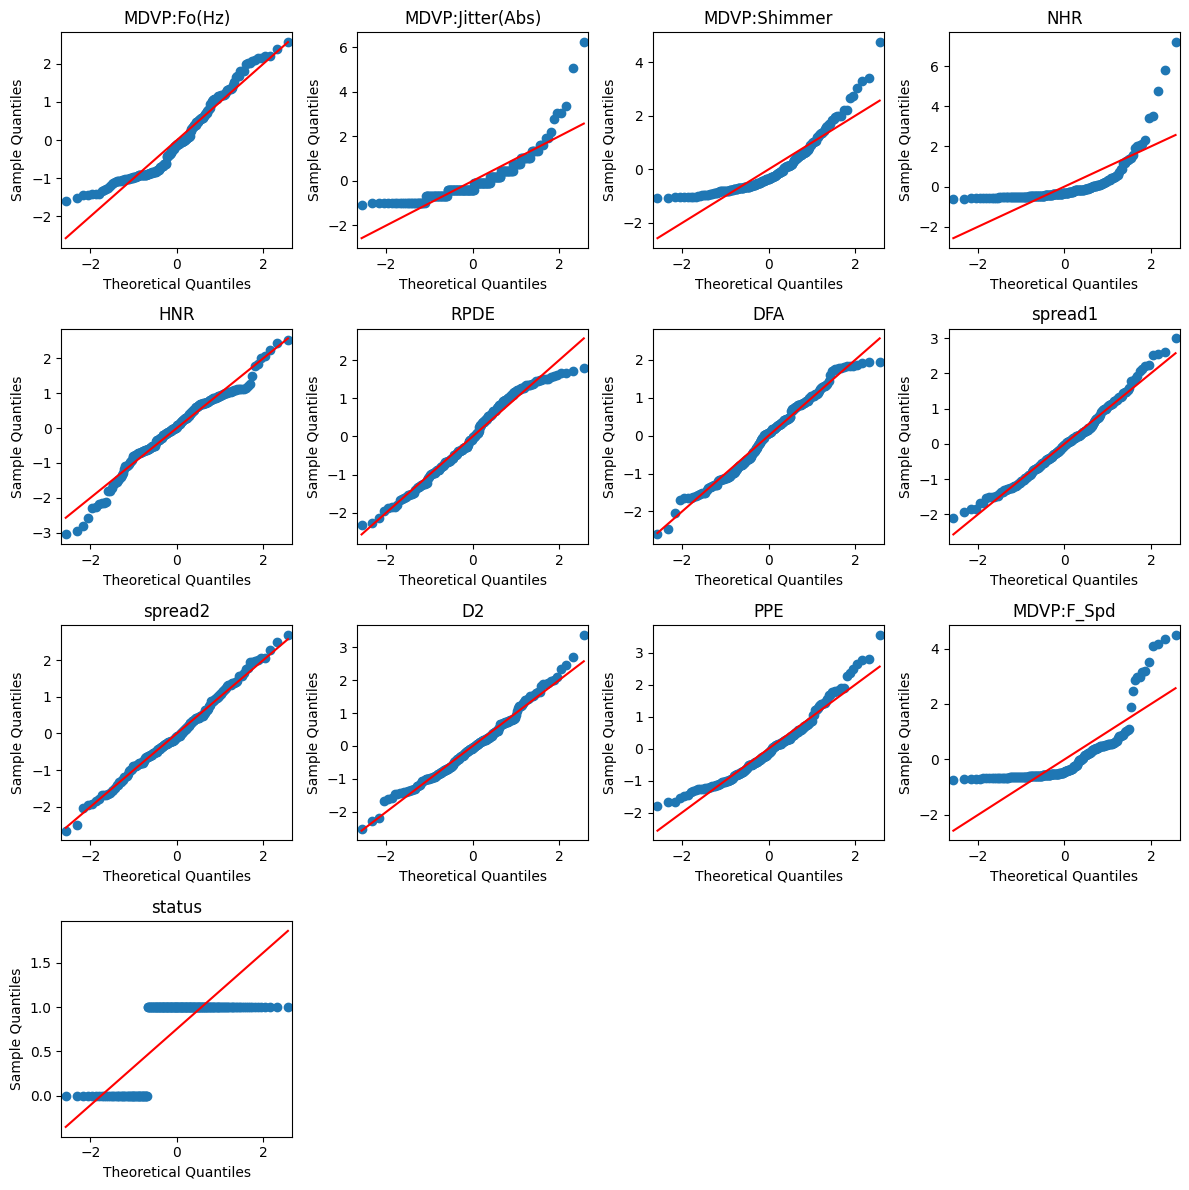

In [184]:
# Create a grid of 3x4 subplots for the Q-Q plots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

# Flatten the array of subplots for easier iteration
axes = axes.flatten()

# Iterate over each variable in the DataFrame and plot its Q-Q plot on a subplot
for i, col in enumerate(df_scaled.columns):
    sm.graphics.qqplot(df_scaled[col], line='s', ax=axes[i])
    axes[i].set_title(col)

# Remove any extra subplots
for i in range(len(df_scaled.columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust the spacing between subplots and display the plot
fig.tight_layout()
plt.show()

In [215]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the independent and dependent variables
X = df_scaled.drop(['status'], axis=1)
y = df_scaled['status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=890)

# Instantiate the Ridge regression model
ridge_model = Ridge(alpha=1.0)

# Fit the model on the training data
ridge_model.fit(X_train, y_train)

# Predict the target variable on the test data
y_pred = ridge_model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

Mean squared error: 0.11942165881024724


In [216]:
from sklearn.linear_model import RidgeCV

# Create a RidgeCV object
ridgecv = RidgeCV(alphas=[0.01, 0.1, 1.0, 5, 10.0, 15, 25, 50, 100])

# Fit the RidgeCV object to the data
ridgecv.fit(X_train, y_train)

# Print the optimal alpha value
print(f"Optimal alpha value: {ridgecv.alpha_}")


Optimal alpha value: 1.0


In [217]:
# Instantiate the Ridge regression model
ridge25_model = Ridge(alpha=25.0)

# Fit the model on the training data
ridge25_model.fit(X_train, y_train)

# Predict the target variable on the test data
y_pred_25 = ridge25_model.predict(X_test)

# Evaluate the model performance
mse_25 = mean_squared_error(y_test, y_pred_25)
print(f"Mean squared error: {mse_25}")

Mean squared error: 0.1290704911993106


In [204]:
from sklearn.metrics import r2_score

r2_25 = r2_score(y_test, y_pred_25)

# calculate the adjusted R-squared value
n = len(X_test)
k = X_test.shape[1]
adj_r2_25 = 1 - ((1 - r2_25) * (n - 1) / (n - k - 1))

print(f"R-squared for a = 25: {r2_25:.4f}")
print(f"Adjusted R-squared for a = 25: {adj_r2_25:.4f}")

R-squared for a = 25: 0.3649
Adjusted R-squared for a = 25: 0.0718


In [218]:
r2 = r2_score(y_test, y_pred)

# calculate the adjusted R-squared value
n = len(X_test)
k = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")

R-squared: 0.4394
Adjusted R-squared: -0.4202


In [281]:
df_pc = data

In [282]:
df_pc.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE', 'status', 'MDVP:F_Spd'],
      dtype='object')

In [283]:
df_pc = df_pc.drop(['name'], axis = 1)

In [284]:
df_pc1 = df_pc[variation_freq]

In [285]:
df_pc1 = scaler.fit_transform(df_pc1)

In [286]:
pca = PCA()
pca.fit(df_pc1)
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

[9.64162746e-01 2.33046731e-02 1.11199310e-02 1.41256948e-03
 7.99702317e-08]


In [287]:
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1
print(num_components)

1


In [288]:
eigenvalues = pca.explained_variance_
print(eigenvalues)

[4.84566329e+00 1.17124001e-01 5.58862511e-02 7.09925385e-03
 4.01912247e-07]


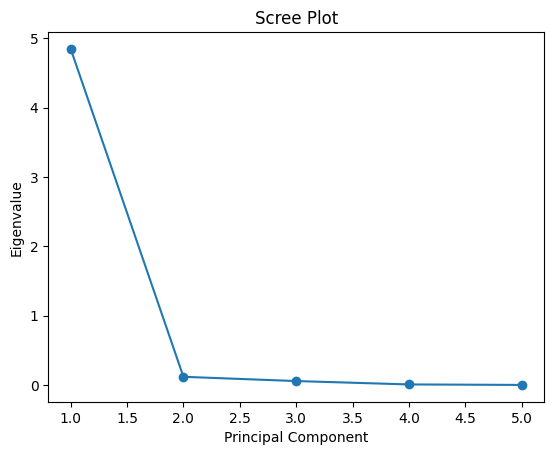

In [289]:
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

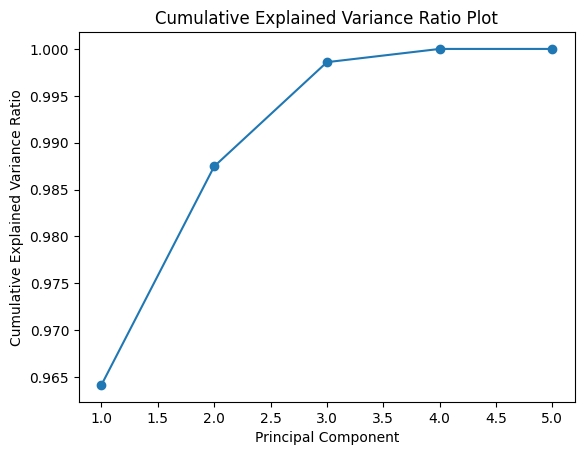

1


In [290]:
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(np.arange(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio Plot')
plt.show()

num_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(num_components)


In [291]:
pca = PCA(n_components=num_components)
data_transformed = pca.fit_transform(df_pc1)

In [293]:
data_transformed = pd.DataFrame(data_transformed, columns = ['Jitter_pc'])
df_pc1 = pd.DataFrame(df_pc1, columns = ['MDVP:Jitter(%)','MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP'])

In [294]:
data_transformed

,Jitter_pc
0,0.934818
1,1.751692
2,2.333009
3,2.020036
4,3.346368
...,...
190,-0.671672
191,-0.312219
192,2.393083
193,0.254103


In [296]:
df_pc['Jitter_pc'] = data_transformed['Jitter_pc']

In [299]:
df_pc.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE', 'status', 'MDVP:F_Spd', 'Jitter_pc'],
      dtype='object')

In [302]:
pca2 = PCA()
df_pc2 = df_pc[variation_amp]
df_pc2 = scaler.fit_transform(df_pc2)

pca2.fit(df_pc2)
explained_variance_ratio = pca2.explained_variance_ratio_
print(explained_variance_ratio)

[9.67891293e-01 2.39668230e-02 4.97378202e-03 2.88262892e-03
 2.85467090e-04 6.01341259e-09]


In [303]:
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1
print(num_components)

1


In [304]:
eigenvalues = pca2.explained_variance_
print(eigenvalues)

[5.83728254e+00 1.44542180e-01 2.99965204e-02 1.73849270e-02
 1.72163142e-03 3.62664574e-08]


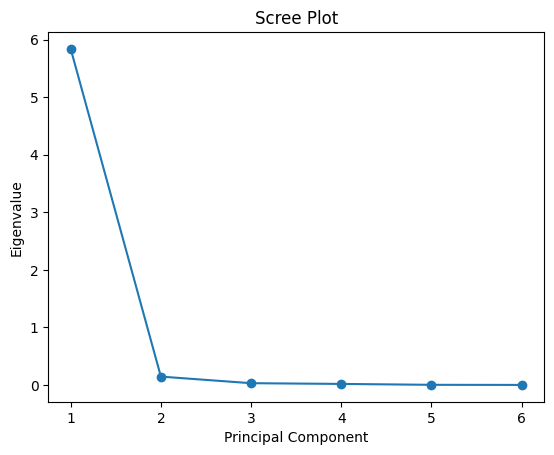

In [305]:
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

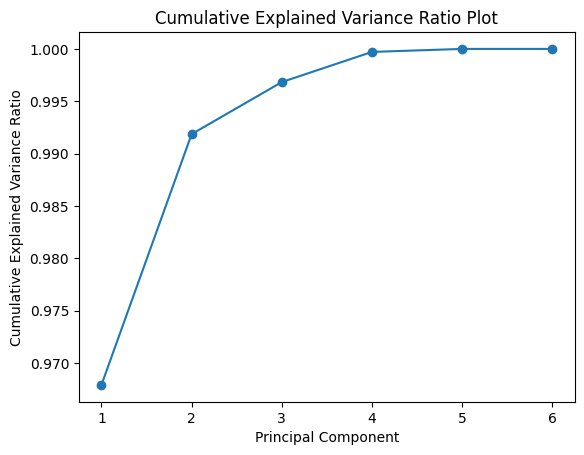

1


In [306]:
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(np.arange(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio Plot')
plt.show()

num_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(num_components)

In [307]:
pca2 = PCA(n_components=num_components)
data_transformed2 = pca2.fit_transform(df_pc2)

In [308]:
data_transformed2 = pd.DataFrame(data_transformed2, columns = ['Shimmer_pc'])
df_pc2 = pd.DataFrame(df_pc2, columns = ['MDVP:Shimmer', 'MDVP:Shimmer(dB)','Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA'])

In [309]:
df_pc['Shimmer_pc'] = data_transformed2['Shimmer_pc']

In [311]:
df_pc = df_pc.drop(['MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
                    'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
                    'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
                    'MDVP:APQ', 'Shimmer:DDA'], axis = 1)

In [312]:
df_pc.head(7)

,MDVP:Fo(Hz),NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status,MDVP:F_Spd,Jitter_pc,Shimmer_pc
0,119.992,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1,82.305,0.934818,1.700278
1,122.400,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1,34.831,1.751692,4.081638
2,116.682,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1,19.556,2.333009,2.865896
3,116.676,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1,26.505,2.020036,3.224675
4,116.014,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1,31.126,3.346368,4.471558
5,120.552,0.01222,21.378,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775,1,17.375,1.832739,2.152991
6,120.267,0.00607,24.886,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756,1,22.424,-1.211720,-1.775359


In [346]:
X = df_pc.drop(['status'], axis=1)
y = df_pc['status']

In [314]:
X_train , X_test , y_train , y_test = train_test_split(X, y , test_size=0.3, random_state=20)

### Decision Tree

In [317]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
predDT = clf.predict(X_test)

print(classification_report(y_test, predDT))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        17
           1       0.95      0.90      0.93        42

    accuracy                           0.90        59
   macro avg       0.87      0.89      0.88        59
weighted avg       0.90      0.90      0.90        59



In [327]:
param_grid = { 
    'max_depth' :range(1,10),
    'random_state':range(30,210,30),
    'criterion' :['gini', 'entropy']
}
CV_dt = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'random_state': range(30, 210, 30)})

In [328]:
CV_dt.best_params_

{'criterion': 'gini', 'max_depth': 1, 'random_state': 30}

In [329]:
dt1=DecisionTreeClassifier(random_state=30, max_depth=1, criterion='gini')
dt1.fit(X_train, y_train)
predDT = dt1.predict(X_test) 
print(classification_report(y_test, predDT))

              precision    recall  f1-score   support

           0       0.69      0.65      0.67        17
           1       0.86      0.88      0.87        42

    accuracy                           0.81        59
   macro avg       0.77      0.76      0.77        59
weighted avg       0.81      0.81      0.81        59



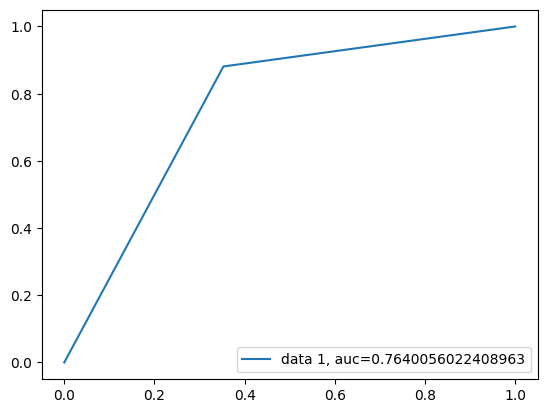

In [330]:
y_pred_proba = dt1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Random forest

In [320]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predRF = rfc.predict(X_test)

print(classification_report(y_test, predRF))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82        17
           1       0.97      0.86      0.91        42

    accuracy                           0.88        59
   macro avg       0.85      0.90      0.87        59
weighted avg       0.90      0.88      0.89        59



In [323]:
param_grid = { 
    'n_estimators': range(100,300,25),
    'max_depth' :range(1,10),
    'random_state':range(100,250,50),
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'n_estimators': range(100, 300, 25),
                         'random_state': range(100, 250, 50)})

In [324]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'n_estimators': 225,
 'random_state': 200}

In [325]:
rfc1=RandomForestClassifier(random_state=200, n_estimators= 225, max_depth=6, criterion='entropy')
rfc1.fit(X_train, y_train)
predRFC = rfc1.predict(X_test)
print(classification_report(y_test, predRFC))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78        17
           1       0.93      0.88      0.90        42

    accuracy                           0.86        59
   macro avg       0.83      0.85      0.84        59
weighted avg       0.87      0.86      0.87        59



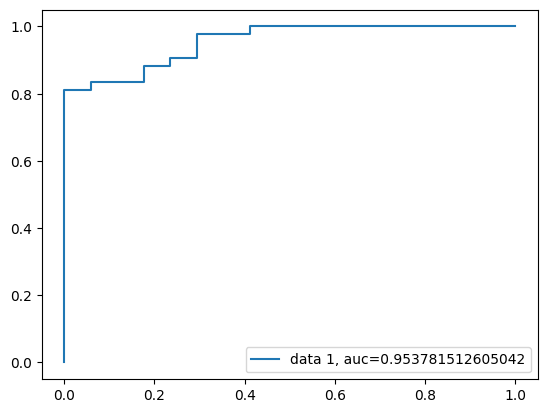

In [331]:
y_pred_proba = rfc1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### SVM

In [332]:
grid_SVC = svm.SVC(C = 100, gamma = 1, kernel = 'linear')
grid_SVC.fit(X_train, y_train)



predSVC = grid_SVC.predict(X_test) 
  
# print classification report 
print("\n", classification_report(y_test, predSVC))


               precision    recall  f1-score   support

           0       0.58      0.65      0.61        17
           1       0.85      0.81      0.83        42

    accuracy                           0.76        59
   macro avg       0.71      0.73      0.72        59
weighted avg       0.77      0.76      0.77        59



In [333]:
param_grid = {'kernel':['linear','rbf','poly'],'C': [0.5, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

grid_SVC = GridSearchCV(svm.SVC(), param_grid, scoring='f1', verbose = 3)
grid_SVC.fit(X_train, y_train)

# print best parameter after tuning 
print("\nBest Parameters: ", grid_SVC.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END .....C=0.5, gamma=1, kernel=linear;, score=0.837 total time=   0.1s
[CV 2/5] END .....C=0.5, gamma=1, kernel=linear;, score=0.889 total time=   0.1s
[CV 3/5] END .....C=0.5, gamma=1, kernel=linear;, score=0.933 total time=   0.0s
[CV 4/5] END .....C=0.5, gamma=1, kernel=linear;, score=0.977 total time=   0.1s
[CV 5/5] END .....C=0.5, gamma=1, kernel=linear;, score=0.930 total time=   0.0s
[CV 1/5] END ........C=0.5, gamma=1, kernel=rbf;, score=0.857 total time=   0.0s
[CV 2/5] END ........C=0.5, gamma=1, kernel=rbf;, score=0.875 total time=   0.0s
[CV 3/5] END ........C=0.5, gamma=1, kernel=rbf;, score=0.875 total time=   0.0s
[CV 4/5] END ........C=0.5, gamma=1, kernel=rbf;, score=0.875 total time=   0.0s
[CV 5/5] END ........C=0.5, gamma=1, kernel=rbf;, score=0.875 total time=   0.0s
[CV 1/5] END .......C=0.5, gamma=1, kernel=poly;, score=0.905 total time= 1.0min
[CV 2/5] END .......C=0.5, gamma=1, kernel=poly

[CV 2/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.900 total time= 1.2min
[CV 3/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.850 total time=  13.1s
[CV 4/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.878 total time=  24.7s
[CV 5/5] END .......C=1, gamma=0.1, kernel=poly;, score=0.821 total time=   4.4s
[CV 1/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.864 total time=   0.0s
[CV 2/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.889 total time=   0.1s
[CV 3/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.933 total time=   0.2s
[CV 4/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.977 total time=   0.1s
[CV 5/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.930 total time=   0.1s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.894 total time=   0.0s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.894 total time=   0.0s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.894 total time=   0.0s
[CV 4/5] END .......C=1, gam

[CV 1/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.913 total time=   1.1s
[CV 2/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.894 total time=   0.3s
[CV 3/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.857 total time=   0.4s
[CV 4/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.927 total time=   0.3s
[CV 5/5] END ....C=10, gamma=0.001, kernel=poly;, score=0.821 total time=   0.9s
[CV 1/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.837 total time=   1.1s
[CV 2/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.889 total time=   0.8s
[CV 3/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.913 total time=   0.5s
[CV 4/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.977 total time=   0.6s
[CV 5/5] END .C=10, gamma=0.0001, kernel=linear;, score=0.952 total time=   0.2s
[CV 1/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.889 total time=   0.0s
[CV 2/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.894 total time=   0.0s
[CV 3/5] END ....C=10, gamma

In [334]:
# print how our model looks after hyper-parameter tuning
print("\n", grid_SVC.best_estimator_)

predSVC = grid_SVC.predict(X_test) 
  
# print classification report 
print("\n", classification_report(y_test, predSVC))


 SVC(C=100, gamma=0.0001, kernel='poly')

               precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.85      0.95      0.90        42

    accuracy                           0.85        59
   macro avg       0.84      0.77      0.79        59
weighted avg       0.85      0.85      0.84        59



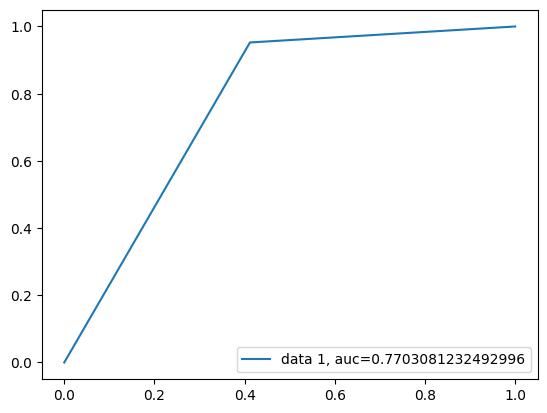

In [335]:
fpr, tpr, _ = metrics.roc_curve(y_test,  predSVC)
auc = metrics.roc_auc_score(y_test, predSVC)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### KNN

In [336]:
Ks = 10
mean_acc = []
ConfustionMx = [];
for n in range(2,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc.append(metrics.accuracy_score(y_test, yhat))  
print('Neighbor Accuracy List')
print(mean_acc)

Neighbor Accuracy List
[0.8813559322033898, 0.864406779661017, 0.864406779661017, 0.8305084745762712, 0.8305084745762712, 0.864406779661017, 0.847457627118644, 0.847457627118644]


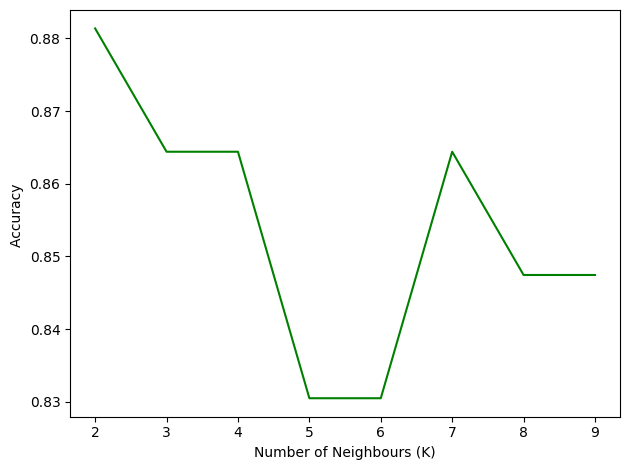

In [337]:
plt.plot(range(2,Ks),mean_acc,'g')
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

In [342]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
predKNN = knn.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.85      0.95      0.90        42

    accuracy                           0.85        59
   macro avg       0.84      0.77      0.79        59
weighted avg       0.85      0.85      0.84        59



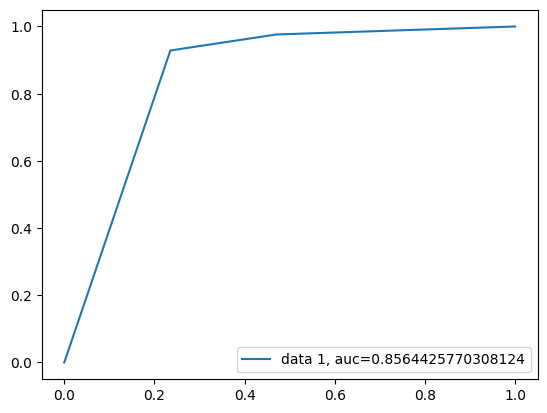

In [343]:
y_pred_proba = knn.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [344]:
from sklearn.metrics import precision_score,recall_score ,accuracy_score, f1_score, r2_score, log_loss

chart = {
        'Metric':["Accuracy", "F1-Score", "Recall", "Precision", "R2-Score"],
        'DT':[accuracy_score(y_test, predDT), f1_score(y_test, predDT), recall_score(y_test, predDT), precision_score(y_test, predDT), r2_score(y_test, predDT)],
        'RF':[accuracy_score(y_test, predRF), f1_score(y_test, predRFC), recall_score(y_test, predRFC), precision_score(y_test, predRFC), r2_score(y_test, predRFC)],
        'SVM':[accuracy_score(y_test, predSVC), f1_score(y_test, predSVC), recall_score(y_test, predSVC), precision_score(y_test, predSVC), r2_score(y_test, predSVC)],
        'KNN':[accuracy_score(y_test, predKNN), f1_score(y_test, predKNN), recall_score(y_test, predKNN), precision_score(y_test, predKNN), r2_score(y_test, predKNN)],
}
chart = pd.DataFrame(chart)
display(chart)

,Metric,DT,RF,SVM,KNN
0,Accuracy,0.813559,0.881356,0.847458,0.881356
1,F1-Score,0.870588,0.902439,0.898876,0.917647
2,Recall,0.880952,0.880952,0.952381,0.928571
3,Precision,0.860465,0.925000,0.851064,0.906977
4,R2-Score,0.091036,0.338936,0.256303,0.421569
